Clone repositories we will be using and install the requirements.

In [ ]:
%tensorflow_version 1.x

!git clone https://github.com/NVIDIA/tacotron2
!sed -i 's/from distributed import/from tacotron2.distributed import/g' "/content/tacotron2/train.py"

!git clone https://github.com/NVIDIA/waveglow
!mv "/content/waveglow/train.py" "/content/waveglow/train2.py"

!pip install -q librosa unidecode

TensorFlow 1.x selected.
Cloning into 'tacotron2'...
remote: Enumerating objects: 406, done.
remote: Total 406 (delta 0), reused 0 (delta 0), pack-reused 406
Receiving objects: 100% (406/406), 2.69 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (205/205), done.
Cloning into 'waveglow'...
remote: Enumerating objects: 190, done.
remote: Total 190 (delta 0), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (190/190), 435.59 KiB | 4.23 MiB/s, done.
Resolving deltas: 100% (106/106), done.
     |████████████████████████████████| 245kB 7.0MB/s 


In [ ]:
import sys

sys.path.append('tacotron2/')
sys.path.append('waveglow/')

# Tacotron2 + WaveGlow

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

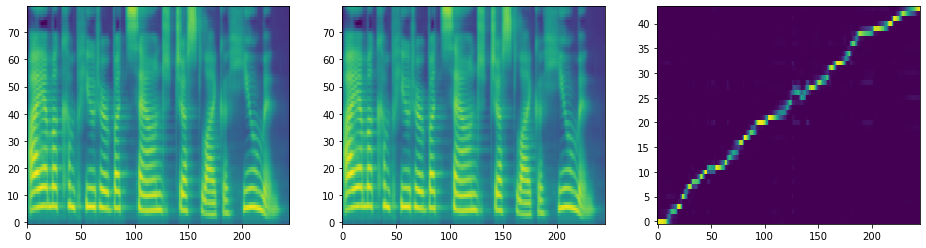

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

hparams = create_hparams()
hparams.sampling_rate = 22050

checkpoint_path = "/content/drive/MyDrive/gt_pretrained_models/tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

text = "I am a computer but sound just like a human."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

waveglow_path = '/content/drive/MyDrive/gt_pretrained_models/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()

denoiser = Denoiser(waveglow)

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.7)
    audio = denoiser(audio, strength=0.05)[:, 0]

ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)